<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring Drop Spreading Law

Euan Baldwin - 10818421<br>
University of Manchester  
February 2021

We first initialise our Python interpreter

In [1]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

![](./img/bee.png)
## Experimental Data

This is data that you are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [2]:
# Radius data 
# experiment 1
radius_data1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
radius_data2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
radius_data3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
time = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

In [3]:
# Error calculation
radius = np.array([radius_data1, radius_data2, radius_data3])
radius_mean = np.mean(radius, axis=0)
radius_err = np.std(radius, axis=0)

Let's plot this data to see what it looks like:

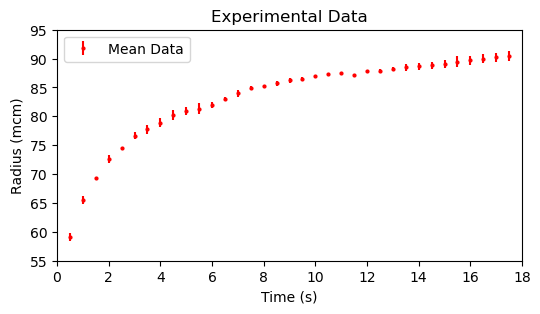

In [4]:
# tweeking the figure size
plt.rcParams['figure.figsize'] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.errorbar(time, radius_mean, radius_err, fmt='o', c='r', ms=2, label='Mean Data')
# setting axis labels & figures 
plt.xlabel('Time (s)')
plt.ylabel('Radius (mcm)')
plt.title('Experimental Data')
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.xlim(0, 18)
plt.legend()
# displaying the plot
plt.show()

Don't forget to find the errors on $R$ estimated from the three experimental runs.

![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

To speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

In [5]:
def speed_func(radius, time):
    '''
    Calculates the speed of an object given its radius at different points in time.

    Parameters
    ----------
    radius : array_like
        Array of radius values representing the distance traveled by the object at different time points.
    time : array_like
        Array of time values corresponding to the radius values.

    Returns
    -------
    speeds : ndarray
        Array of speed values at each time point, calculated as the difference between consecutive radius values
        divided by the corresponding time interval.
    '''
    return np.diff(radius)/np.diff(time)

def volume_func(max_height, radius):
    '''
     Calculates the volume of a spherical cap given its maximum height and radius.

    Parameters
    ----------
    max_height : float or int
        The maximum height of the spherical cap.
    radius : float or int
        The radius of the spherical cap.

    Returns
    -------
    volume : float
        The volume of the spherical cap, in cubic units.
    '''
    return np.pi / 6 * max_height * (3 * radius ** 2 + max_height ** 2) - 7600

def height_func(radius):
    '''
    """
    Calculates the maximum height of a spherical cap given its radius.

    Parameters
    ----------
    radius : array_like
        An array of radius values representing the different spherical caps.

    Returns
    -------
    max_heights : ndarray
        An array of maximum height values corresponding to the input radius values.
    '''
    max_heights = []
    for radii in radius:
        height = fsolve(lambda max_height: volume_func(max_height, radii), 0)
        max_heights = np.append(max_heights, height)
    return max_heights

def angle_func(height, radius):
    '''
    Calculates the angle between the top of a spherical cap and its base, given its maximum height and radius.

    Parameters
    ----------
    height : float or int
        The maximum height of the spherical cap.
    radius : float or int
        The radius of the spherical cap.

    Returns
    -------
    angle : float
        The angle between the top of the spherical cap and its base, in radians.
    '''
    return  (np.pi / 2) - np.arctan((radius ** 2 - height ** 2) / (2 * radius * height))


speed = [speed_func(radius[0], time), speed_func(radius[1], time), speed_func(radius[2], time)]
max_height = [height_func(radius[0]), height_func(radius[1]), height_func(radius[2])]
angle = [angle_func(max_height[0], radius[0]), angle_func(max_height[1], radius[1]),
                 angle_func(max_height[2], radius[2])]

Let's plot these results to see what they look like:

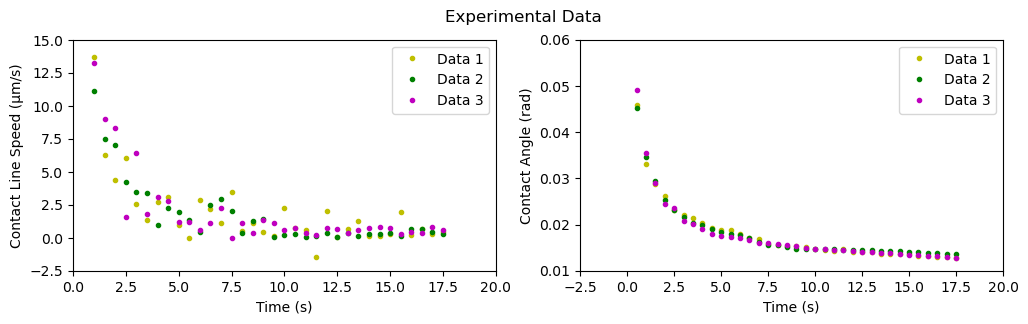

In [6]:
plt.rcParams['figure.figsize'] = (12,3)
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Experimental Data')

ax1.plot(time[1:], speed[0], 'yo', ms=3, label='Data 1')
ax1.plot(time[1:], speed[1], 'go', ms=3, label='Data 2')
ax1.plot(time[1:], speed[2], 'mo', ms=3, label='Data 3')
ax1.set(xlabel='Time (s)', ylabel='Contact Line Speed (µm/s)')
ax1.legend()

ax2.plot(time, angle[0], 'yo', ms=3, label='Data 1')
ax2.plot(time, angle[1], 'go', ms=3, label='Data 2')
ax2.plot(time, angle[2], 'mo', ms=3, label='Data 3')
ax2.set(xlabel='Time (s)', ylabel='Contact Angle (rad)')
ax2.legend()

plt.show()

The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

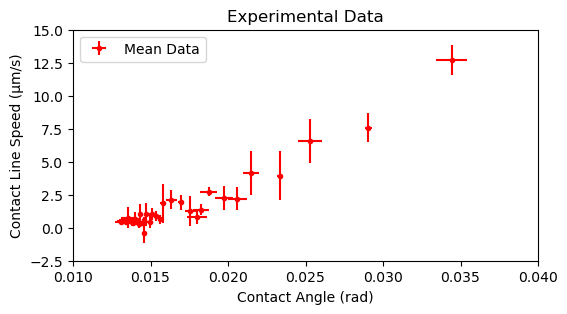

In [7]:
angle_mean = np.mean(angle, axis=0)
angle_err = np.std(angle, axis=0)

speed_mean = np.mean(speed, axis=0)
speed_err = np.std(speed, axis=0)

plt.rcParams['figure.figsize'] = (6,3)
plt.figure()
plt.errorbar(angle_mean[1:], speed_mean, speed_err, angle_err[1:], fmt='o', ms=3, c='r', label='Mean Data')
plt.xlabel('Contact Angle (rad)')
plt.ylabel('Contact Line Speed (µm/s)')
plt.title('Experimental Data')
plt.legend()
plt.show()

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [8]:
# Cox-Voinov has been abbreviated to cv and de Gennes to dg
theta2 = angle_mean[1:] ** 2
dg_popt, dg_pcov = np.polyfit(theta2, speed_mean, 1, cov=True)
dg_perr = np.sqrt(np.diag(dg_pcov))
dg_v_0 = dg_popt[0]
dg_v_0_err = dg_perr[0]
dg_theta_0 = np.sqrt(abs(dg_popt[1]) / dg_v_0)
dg_theta_0_err = np.sqrt(np.square(- 1 / (2 * dg_v_0 * dg_theta_0) * dg_perr[1])
                    + np.square(dg_popt[1] / (2 * dg_v_0 ** 2 * dg_theta_0) * dg_v_0_err))
u_dg = np.polyval(dg_popt, theta2)

theta3 = angle_mean[1:] ** 3
cv_popt, cv_pcov = np.polyfit(theta3, speed_mean, 1, cov=True)
cv_perr = np.sqrt(np.diag(cv_pcov))
cv_v_0 = cv_popt[0]
cv_v_0_err = cv_perr[0]
cv_theta_0 = np.sqrt(abs(cv_popt[1]) / cv_v_0)
cv_theta_0_err = np.sqrt(np.square(- 1 / (2 * cv_v_0 * cv_theta_0) * cv_perr[1])
                    + np.square(cv_popt[1] / (2 * cv_v_0 ** 2 * cv_theta_0) * cv_v_0_err))
u_cv = np.polyval(cv_popt, theta3)

Displaying the corresponding fits  

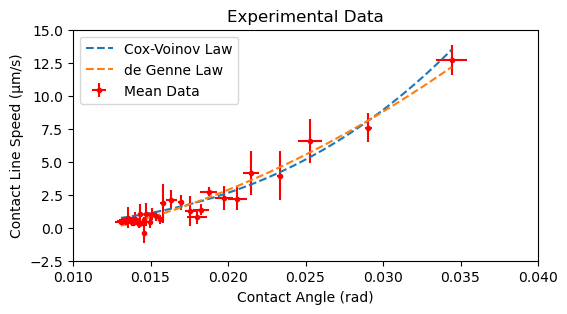

In [9]:
def cv_law(theta, theta_0, v_0):
    '''
    The Cox-Voinov Law
    
    Parameters
    ----------
    theta : float or int
        The angle between the top of the spherical cap and its base, in radians.
    theta_0 : float or int
        The initial theta value.
    v_0 : float or int
        The initial contact line speed.

    Returns
    -------
    Contact line speed : float or int
    '''
    return v_0 * (theta ** 3 - theta_0 ** 3)

def dg_law(theta, theta_0, v_0):
    '''
    The de Gennes Law
    
    Parameters
    ----------
    theta : float or int
        The angle between the top of the spherical cap and its base, in radians.
    theta_0 : float or int
        The initial theta value.
    v_0 : float or int
        The initial contact line speed.

    Returns
    -------
    Contact line speed : float or int
    '''
    return v_0 * (theta ** 2 - theta_0 ** 2)

x = np.linspace(min(angle_mean[1:]), max(angle_mean[1:]), 1000)
y_cv = cv_law(x, cv_theta_0, cv_v_0)
y_dg = dg_law(x, dg_theta_0, dg_v_0)

# Plotting the figures
plt.rcParams['figure.figsize'] = (6,3)
plt.figure()
plt.plot(x, y_cv, '--', label='Cox-Voinov Law')
plt.plot(x, y_dg, '--', label='de Genne Law')
plt.errorbar(angle_mean[1:], speed_mean, speed_err, angle_err[1:], fmt='o', ms=3, c='r', label='Mean Data')
plt.xlabel('Contact Angle (rad)')
plt.ylabel('Contact Line Speed (µm/s)')
plt.title('Experimental Data')
plt.legend()
plt.show()

![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. 

Cox-Voinov law:
v₀ = (330612 ± 12601) µm/s
θ₀ = (0.0009 ± 0.0002) radians

de Gennes law:
v₀ = (11851 ± 439) µm/s
θ₀ = (0.0126 ± 0.0006) radians


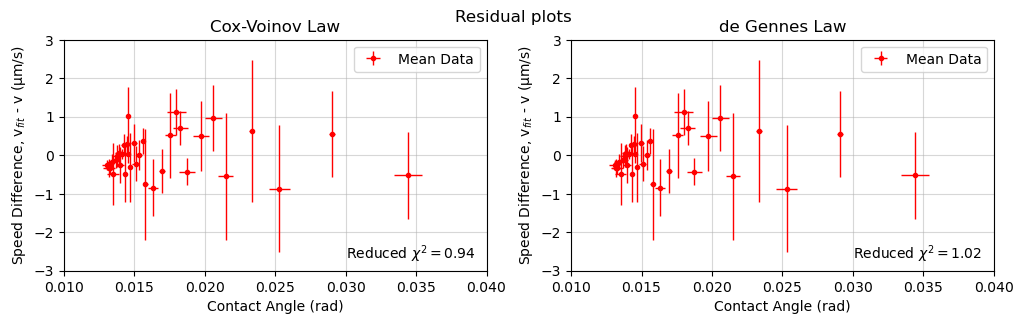

In [10]:
def rcs(v, v_sigma, v_fit, n):
    '''
    Calculate the reduced chi-squared (rcs) value for a given set of data points.
    
    Parameters
    ----------
    v : array-like
        Array of actual data points.
    v_sigma : array-like
        Array of standard deviations of each data point.
    v_fit : array-like
        Array of fitted values corresponding to each data point.
    n : int 
        Number of free parameters in the fitting model.
    
    Returns
    -------
    Reduced chi-squared value for the given data set : float
    '''
    return sum(np.square((v - v_fit) / v_sigma)) / (len(v) - n)

dg_rcs = rcs(speed_mean, speed_err, u_dg, 2)
cv_rcs = rcs(speed_mean, speed_err, u_cv, 2)

print(f'Cox-Voinov law:\nv₀ = ({cv_v_0:.0f} ± {cv_v_0_err:.0f}) µm/s'
      f'\nθ₀ = ({cv_theta_0:3.4f} ± {cv_theta_0_err:.4f}) radians'
      f'\n\nde Gennes law:\nv₀ = ({dg_v_0:.0f} ± {dg_v_0_err:.0f}) µm/s'
      f'\nθ₀ = ({dg_theta_0:3.4f} ± {dg_theta_0_err:.4f}) radians')

# Plotting the figures
plt.rcParams['figure.figsize'] = (12,3)
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Residual plots')

ax1.errorbar(angle_mean[1:], u_dg - speed_mean, speed_err, angle_err[1:], elinewidth=1,
             fmt='o', ms=3, c='r', label='Mean Data')
ax1.set(xlabel='Contact Angle (rad)', ylabel=r'Speed Difference, v$_{fit}$ - v (µm/s)')
ax1.set_title('Cox-Voinov Law')
ax1.text(0.03, -2.7, 'Reduced $\chi^2 = {:.2f}$'.format(cv_rcs))
ax1.grid(alpha=0.5)
ax1.legend()

ax2.errorbar(angle_mean[1:], u_dg - speed_mean, speed_err, angle_err[1:], elinewidth=1,
             fmt='o', ms=3, c='r', label='Mean Data')
ax2.set(xlabel='Contact Angle (rad)', ylabel=r'Speed Difference, v$_{fit}$ - v (µm/s)')
ax2.set_title('de Gennes Law')
ax2.text(0.03, -2.7, 'Reduced $\chi^2 = {:.2f}$'.format(dg_rcs))
ax2.grid(alpha=0.5)
ax2.legend()

plt.show()

## Using Weighted Fitting
Here curvefit is used for the fitting, allowing the errors in the contact line speed to be weighted into the fitting process for the optimised parameters

Cox-Voinov law:
v₀ = (336145 ± 22681) µm/s
θ₀ = (0.0105 ± 0.0006) radians

de Gennes law:
v₀ = (10856 ± 740) µm/s
θ₀ = (0.0121 ± 0.0003) radians


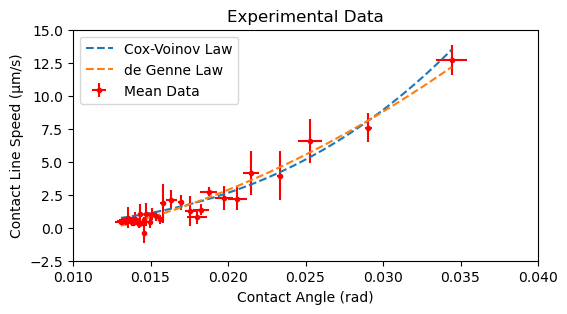

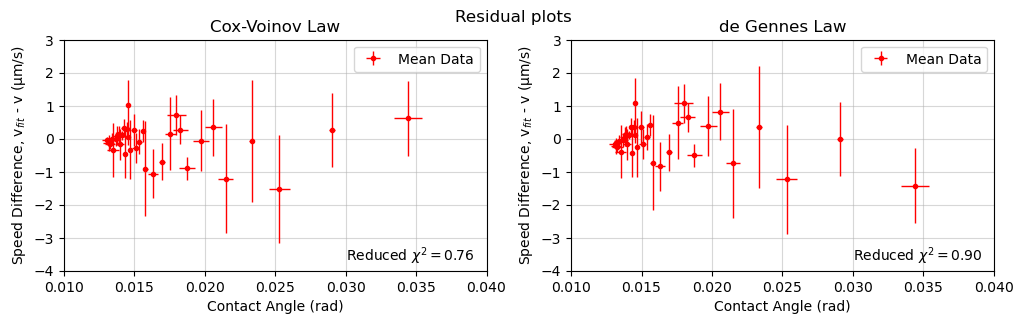

In [11]:
def fit(f, theta, speed, error):
    '''
    Fit a function to given data using curve_fit from scipy.optimize module.

    Parameters:
    -----------
    f: callable
        Function to fit to the data. It must take an independent variable as its first argument.
    theta: array_like
        Independent variable data.
    speed: array_like
        Dependent variable data to be fit by the function.
    error: array_like
        Standard deviation of the dependent variable data.
        
    Returns:
    --------
    tuple
        Tuple of floats and an array. The values correspond to:
            * popt[1]: optimized value of the intercept.
            * perr[1]: standard deviation of the intercept.
            * popt[0]: optimized value of the slope.
            * perr[0]: standard deviation of the slope.
            * vfit: fitted values of speed based on the optimized values of the slope and the intercept.
    '''
    popt, pcov = curve_fit(f, theta, speed, p0=[-1,1000], sigma=error, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    vfit = f(theta, popt[0], popt[1])
    return popt[1], perr[1], popt[0], perr[0], vfit

cv_results = fit(cv_law, angle_mean[1:], speed_mean, speed_err)
dg_results = fit(dg_law, angle_mean[1:], speed_mean, speed_err)

cv_rcs = rcs(speed_mean, speed_err, cv_results[4], 2)
dg_rcs = rcs(speed_mean, speed_err, dg_results[4], 2)

print(f'Cox-Voinov law:\nv₀ = ({cv_results[0]:.0f} ± {cv_results[1]:.0f}) µm/s'
      f'\nθ₀ = ({cv_results[2]:3.4f} ± {cv_results[3]:2.4f}) radians'
      f'\n\nde Gennes law:\nv₀ = ({dg_results[0]:.0f} ± {dg_results[1]:.0f}) µm/s'
      f'\nθ₀ = ({dg_results[2]:3.4f} ± {dg_results[3]:2.4f}) radians')

# Plotting the figures
plt.rcParams['figure.figsize'] = (6,3)
plt.figure()
plt.plot(x, y_cv, '--', label='Cox-Voinov Law')
plt.plot(x, y_dg, '--', label='de Genne Law')
plt.errorbar(angle_mean[1:], speed_mean, speed_err, angle_err[1:], fmt='o', ms=3, c='r', label='Mean Data')
plt.xlabel('Contact Angle (rad)')
plt.ylabel('Contact Line Speed (µm/s)')
plt.title('Experimental Data')
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = (12,3)
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Residual plots')

ax1.errorbar(angle_mean[1:], cv_results[4] - speed_mean, speed_err, angle_err[1:], elinewidth=1,
             fmt='o', ms=3, c='r', label='Mean Data')
ax1.set(xlabel='Contact Angle (rad)', ylabel=r'Speed Difference, v$_{fit}$ - v (µm/s)')
ax1.set_title('Cox-Voinov Law')
ax1.text(0.03, -3.7, 'Reduced $\chi^2 = {:.2f}$'.format(cv_rcs))
ax1.grid(alpha=0.5)
ax1.legend()

ax2.errorbar(angle_mean[1:], dg_results[4] - speed_mean, speed_err, angle_err[1:], elinewidth=1,
             fmt='o', ms=3, c='r', label='Mean Data')
ax2.set(xlabel='Contact Angle (rad)', ylabel=r'Speed Difference, v$_{fit}$ - v (µm/s)')
ax2.set_title('de Gennes Law')
ax2.text(0.03, -3.7, 'Reduced $\chi^2 = {:.2f}$'.format(dg_rcs))
ax2.grid(alpha=0.5)
ax2.legend()

plt.show()

x = np.linspace(min(angle_mean[1:]), max(angle_mean[1:]), 1000)
y_cv = cv_law(x, cv_results[2], cv_results[0])
y_dg = dg_law(x, dg_results[2], dg_results[0])

![](./img/bee.png)
## Drop Spreading Law Is

The results of the chi-squared analysis suggest that the de Gennes law is a better fit for the behaviour of the spreading drop because it's reduced chi-squared value is closer to one (1.02) than the reduced chi squared for the Cox-Voinov law (0.94).

Taking into account the uncertainties in the contact line speed during the fitting process gave the same pattern, however both reduced chi-squared values were smaller than before: 0.90 for the de Gennes law and 0.76 for the Cox-Voinov law.

Both results imply that the range of contact angles were sufficient to produce well fitting datasets.